## acquire

Zillow data:
- 2017 data
- Latest transaction per property id only.
- The logerror from that latest transaction.
- All fields related to the properties.
- Gather descriptions from the lookup tables.
- Only properties with latitude and longitude.
- Only single family homes.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, QuantileTransformer, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")

import acquire
import summarize
import prepare

In [2]:
df = acquire.get_zillow_data()

Only single family

In [3]:
df = df[df.propertylandusedesc == 'Single Family Residential']

## prepare 

### Missing Values

- remove columns with > 99% missing and rows  > 40% missing
- aggregate pool information: use all pool and spa columns to compute a single boolean attribute of `has_pool`
- fill with 0: taxdelinquencyflag, fireplacecnt, garagecarcnt and convert them to boolean
- After doing all that, then remove all columns with > 5% missing, and following that, rows with > 1% missing

In [4]:
# remove columns with > 99% missing and rows  > 40% missing
df = prepare.handle_missing_values(df, prop_required_column = .01, prop_required_row = .40)

In [5]:
# aggregate pool information: use all pool and spa columns to compute a single attribute of pool_spa
# gather pool columns
pool_cols = ['hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid2', 'pooltypeid7']
# fill all missing values with 0
pool = df[pool_cols].fillna(0)
# where there is a value in one or more of the pool attributes, assign a 1 to a new col named 'pool'
pool.loc[pool.sum(axis=1)>0, 'has_pool'] = 1
# append the new column to our original dataframe and remove the original pool columns 
df = df.join(pool[['has_pool']])

# fill with 0
df.loc[df.taxdelinquencyflag == 'Y', 'is_taxdelinquent'] = 1
df.loc[df.fireplacecnt > 0, 'has_fireplace'] = 1
df.loc[df.garagecarcnt > 0, 'has_garage'] = 1
fill_with_0 = ['has_garage', 'has_fireplace', 'has_pool', 'is_taxdelinquent']
df[fill_with_0] = df[fill_with_0].fillna(0)

# remove columns where > 5% missing and rows where > 99% missing
df = prepare.handle_missing_values(df, prop_required_column = .95, prop_required_row = .99)

In [6]:
df.isnull().sum()
df.shape

(50450, 33)

### Variable Changes

Are there any instances where taxvaluedollarcnt is not equal to the sum of the land tax value and the structure tax value? (landtaxvaluedollarcnt + structuretaxvaluedollarcnt). 

In [7]:
np.where((df.taxvaluedollarcnt - (df.landtaxvaluedollarcnt + df.structuretaxvaluedollarcnt)) != 0)
# add taxvaluedollarcnt to list to drop

(array([], dtype=int64),)

No. I will attempt to reduce the dependency between variables and extracting the most unique information from each. 

- `land_dollar_per_sqft`: a land dollar per sqft (landtaxvaluedollarcnt/lotsizesquarefeet)
- `structure_dollar_per_sqft`: structuretaxvaluedollarcnt/calculatedfinishedsquarefeet
- `tax_rate`: taxvaluedollarcnt/taxamount
- compute `living_area_sqft` by subtracting estimated square feet from bedrooms (121: 11x11) and bathrooms (36: 6x6)
- compute `bedbath_index` where multiple bedrooms by a weight of 2, full baths by weight of 1, half/three-quarter baths by weight of .5, then sum them all together.  


In [8]:
df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet
df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
df['living_area_sqft'] = df.calculatedfinishedsquarefeet - (df.bedroomcnt*121 + df.bathroomcnt*36)
df['tax_rate'] = df.taxvaluedollarcnt/df.taxamount
df['bedbath_index'] = df.bedroomcnt*2 + df.fullbathcnt + .5*(df.bathroomcnt-df.fullbathcnt)

- turn yearbuilt into age (from 2017)
- reduce regionidcity into the top 5 cities and the others assign to a catch-all id.
- take the first 3 digits of zip to reduce the variance in zipcode 
- Look at variables that don't actually represent numeric values to think about encoding. (fips, regionidcity, regionidzip, regionidcounty)

In [9]:
df['age'] = 2017 - df.yearbuilt

In [10]:
df.loc[:,'latitude'] = df.loc[:,'latitude']/1e6
df.loc[:,'longitude'] = df.loc[:,'longitude']/1e6

City ID and County: Is there any cross-over or is city purely a subset of county? 

Count the number of counties each city is located in:

In [11]:
ct = pd.DataFrame(pd.crosstab(df.regionidcity, df.regionidcounty))
s = ct.astype(bool).sum(axis=1)
s = s.where(s>1).dropna()
pd.crosstab(df[df.regionidcity.isin(list(s.index))].regionidcity, df[df.regionidcity.isin(list(s.index))].regionidcounty)

regionidcounty  1286.0  2061.0  3101.0
regionidcity                          
5465.0               2       0     210
10608.0            375       0       1
12447.0              0       1   11237
12520.0              0       3     153
15237.0             71       0       3
18874.0            252       0       5
41673.0              0     124       1
44833.0            247       0       1

Taking a look at these, I can see that when there are multiple counties, there is clearly a dominant county and only a handful of properties in the other. I will 'fix' the anomalies to be in what is likely the correct county. I'll test it here, but will need to implement above before we do all the prepping. 

In [12]:
df.loc[df.regionidcity.isin([5465.0,12447.0,12520.0]), 'regionidcounty'] = 3101.0
df.loc[df.regionidcity.isin([10608.0,15237.0,18874.0,44833.0]), 'regionidcounty'] = 1286.0
df.loc[df.regionidcity==41673.0, 'regionidcounty'] = 2061.0
df.regionidcounty.value_counts()

3101.0    32647
1286.0    13500
2061.0     4303
Name: regionidcounty, dtype: int64

- Looking at the counts for each county, it seems reasonable to not split county 2061 geographically much more than that.  
- County 1286 can probably be split more effectively: city 16764 and all others 
- County 3101 can definitedly be split more effectively: city 12447, 5534, 46298, 40227, and all others

However, I'm going to wait to do this. I will first run some statistical tests to see if there are cities and zips that have significantly different logerror from the rest of the properties. 

In [13]:
# df.loc[(df['regionidcity']==12447) | (df['regionidcity']==5534) | (df['regionidcity']==40227) | (df['regionidcity']==46298) | (df['regionidcity']==16764), 'cityid'] = df['regionidcity']
# df.cityid.fillna(0, inplace=True)

In [14]:
# have to do float first because of an issue with 0.0, then int, then string to ensure no decimals in the string.  
# df['cityid'] = df.cityid.astype(float).astype(int).astype(str)
df['regionidcity'] = df.regionidcity.astype(float).astype(int).astype(str)
df['regionidzip'] = df.regionidzip.astype(float).astype(int).astype(str)
df['regionidcounty'] = df.regionidcounty.astype(float).astype(int).astype(str)

In [15]:
# df['loc_id'] = df.regionidcounty + '_' + df.cityid

In [16]:
df.columns

Index(['id', 'parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'transactiondate', 'logerror',
       'propertylandusedesc', 'has_pool', 'is_taxdelinquent', 'has_fireplace',
       'has_garage', 'structure_dollar_per_sqft', 'land_dollar_per_sqft',
       'living_area_sqft', 'tax_rate', 'bedbath_index', 'age'],
      dtype='object')

In [17]:
# clean up remaining columns
df_prepped = df.drop(columns=(['id','parcelid','assessmentyear','propertycountylandusecode',
                               'propertylandusedesc','transactiondate', 'propertylandusetypeid',
                               'finishedsquarefeet12', 'taxvaluedollarcnt', 'fips',
                               'yearbuilt', 'rawcensustractandblock', 'censustractandblock', 'roomcnt', 
                               'calculatedbathnbr','taxamount','calculatedfinishedsquarefeet',
                               'landtaxvaluedollarcnt','structuretaxvaluedollarcnt',
                               'bedroomcnt','bathroomcnt','fullbathcnt'
                              ]))

In [18]:
df_prepped.head().T

0          1           2        3  \
latitude                     33.6349    34.4493     33.8862  34.2452   
longitude                   -117.869   -119.282    -117.823 -118.241   
lotsizesquarefeet               4506      12647        8432    13038   
regionidcity                   53571      13091       21412   396551   
regionidcounty                  1286       2061        1286     3101   
regionidzip                    96978      97099       97078    96330   
logerror                   0.0255949  0.0556191  0.00538285 -0.10341   
has_pool                           0          0           1        1   
is_taxdelinquent                   0          0           0        0   
has_fireplace                      0          1           0        0   
has_garage                         1          1           1        0   
structure_dollar_per_sqft    156.682    60.0683     68.6154  45.8409   
land_dollar_per_sqft         119.301    29.7304     56.8654  2.77842   
living_area_sqft                2490       1187         808     1784   
tax_rate                     92.9098    81.7984     87.0456  81.6552   
bedbath_index                  11.25          5           8       11   
age                               19         50          55       47   

                                    6  
latitude                      34.1452  
longitude                     -118.18  
lotsizesquarefeet               63000  
regionidcity                    47019  
regionidcounty                   3101  
regionidzip                     96293  
logerror                  -0.00101096  
has_pool                            1  
is_taxdelinquent                    0  
has_fireplace                       0  
has_garage                          0  
structure_dollar_per_sqft     93.4112  
land_dollar_per_sqft          7.88284  
living_area_sqft                 2370  
tax_rate                      81.2612  
bedbath_index                      11  
age                                67

### Split Data

In [19]:
train, test = train_test_split(df_prepped, test_size=.30)

### Scaling

#### Create Uniform Scaler
when we the space between doesn't matter as much as order does, a uniform scaler is a good choice. 

In [20]:
def scale_uniform(train, test, column_list):
    scaler = QuantileTransformer(output_distribution='uniform', random_state=123)
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

#### Create MinMax Scaler
When we want to preserve distance but want to be within bounds, a min-max scaler is a good choice. 

In [21]:
def scale_minmax(train, test, column_list):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

We will scale square feet, dollar per square foot, tax rate, beds & baths using a uniform scaler as that will help minimize the impact extreme outliers will have. 

For latitude, longitude and age, we want to preserve the distance between. We want 1876 to be futher away from the next oldest house of 1900 than 1900 is from the next oldest house of 1901. For this reason, we will use a min-max scaler. 

In [22]:
column_list1 = ['lotsizesquarefeet','structure_dollar_per_sqft','land_dollar_per_sqft','living_area_sqft','tax_rate','bedbath_index']
train, test, scaler_uniform = scale_uniform(train, test, column_list1)

column_list2 = ['latitude','longitude','age']
train, test, scaler_minmax = scale_minmax(train, test, column_list2)

In [23]:
train.describe().T

count      mean       std           min  \
logerror                   35315.0  0.017976  0.176753 -4.655420e+00   
has_pool                   35315.0  0.219567  0.413959  0.000000e+00   
is_taxdelinquent           35315.0  0.039643  0.195122  0.000000e+00   
has_fireplace              35315.0  0.140790  0.347810  0.000000e+00   
has_garage                 35315.0  0.347133  0.476065  0.000000e+00   
lotsizesquarefeet          35315.0  0.499993  0.288689  1.000000e-07   
structure_dollar_per_sqft  35315.0  0.500001  0.288683  1.000000e-07   
land_dollar_per_sqft       35315.0  0.499999  0.288687  1.000000e-07   
living_area_sqft           35315.0  0.500001  0.288684  1.000000e-07   
tax_rate                   35315.0  0.500000  0.288686  1.000000e-07   
bedbath_index              35315.0  0.500008  0.285561  1.000000e-07   
latitude                   35315.0  0.459551  0.183736  0.000000e+00   
longitude                  35315.0  0.673092  0.186937  0.000000e+00   
age                        35315.0  0.404571  0.173754  0.000000e+00   

                                25%       50%       75%       max  
logerror                  -0.024689  0.006769  0.040192  3.394544  
has_pool                   0.000000  0.000000  0.000000  1.000000  
is_taxdelinquent           0.000000  0.000000  0.000000  1.000000  
has_fireplace              0.000000  0.000000  0.000000  1.000000  
has_garage                 0.000000  0.000000  1.000000  1.000000  
lotsizesquarefeet          0.249972  0.500021  0.749972  1.000000  
structure_dollar_per_sqft  0.249956  0.500111  0.749919  1.000000  
land_dollar_per_sqft       0.249995  0.500080  0.750091  1.000000  
living_area_sqft           0.250250  0.499903  0.750000  1.000000  
tax_rate                   0.250016  0.499814  0.749995  1.000000  
bedbath_index              0.244745  0.379880  0.752252  1.000000  
latitude                   0.328764  0.459478  0.570758  1.000000  
longitude                  0.566664  0.694366  0.811725  1.000000  
age                        0.290076  0.427481  0.503817  1.000000

## Cluster

### K-Means

#### Elbow Method to determine best 'K'

1. Let's first cluster by geolocation of latitude and longitude along with dollar per square foot (land and structure) and tax rate.

2. Then we will cluster by lot size, living area, beds and baths, and age. 

##### Clustering 1: location, dollar/sqft, tax rate

In [24]:
cluster1_cols = ['latitude','longitude','land_dollar_per_sqft','structure_dollar_per_sqft']

Compute and plot the sum squared distances of each sample to closest cluster center at each k-value.  

In [25]:
def select_k(cluster_df, ks):
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
        kmeans.fit(cluster_df)

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_)

    # print(pd.DataFrame(dict(k=ks, sse=sse)))

    p = plt.plot(ks, sse, 'bx-')
    p = plt.xlabel('k')
    p = plt.ylabel('SSE')
    p = plt.title('The Elbow Method to find the optimal k')

    compare_df = pd.DataFrame(dict(k=ks, sse=sse)).assign(change_in_sse=lambda df: df.sse.diff())
    return compare_df, p

(     k          sse  change_in_sse
 0    1  8312.309976            NaN
 1    2  5201.077330   -3111.232646
 2    3  4043.527616   -1157.549713
 3    4  3243.117684    -800.409932
 4    5  2814.326809    -428.790875
 5    6  2426.776342    -387.550468
 6    7  2216.739627    -210.036714
 7    8  2060.089100    -156.650528
 8    9  1832.923533    -227.165567
 9   10  1695.627711    -137.295822
 10  11  1638.722424     -56.905287
 11  12  1526.413205    -112.309219,
 Text(0.5, 1.0, 'The Elbow Method to find the optimal k'))

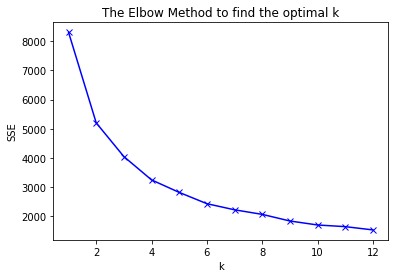

In [26]:
select_k(cluster_df = train[cluster1_cols], ks = range(1,13))

I would say 6 or 8 is hwere the bottom of the elbow sits.  
Let's compare k=6 vs. k=8. 

In [27]:
def compare_clusters(cluster_df, x_column, y_column, z_column, k1, k2):
    estimators = [(str(k1)+' Clusters', KMeans(n_clusters=k1, n_init=1, max_iter=100, random_state=123)),
                  (str(k2)+' Clusters', KMeans(n_clusters=k2, n_init=1, max_iter=100, random_state=123))]
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})
    
    for ax, (title, kmeans) in zip(axs, estimators):
        # fit the kmeans object
        kmeans.fit(cluster_df)
        
        labels = kmeans.labels_
        
        ax.scatter(cluster_df[x_column], 
                   cluster_df[y_column],
                   cluster_df[z_column],
                   c=labels.astype(np.float), edgecolor='k')
        ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
        ax.set(xlabel=x_column, ylabel=y_column, zlabel=z_column)
        ax.set(title=title)
    
    plt.show()

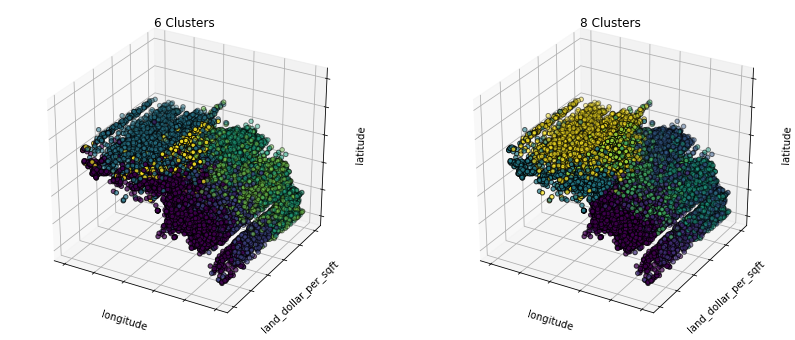

In [28]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='longitude', y_column='land_dollar_per_sqft', z_column='latitude',
                k1=6, k2=8)

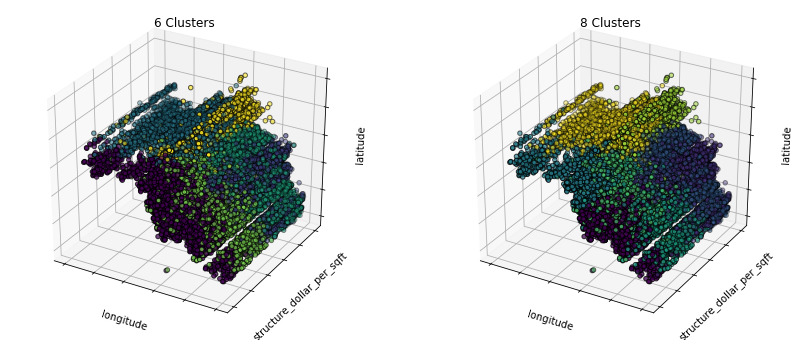

In [29]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='longitude', y_column='structure_dollar_per_sqft', z_column='latitude',
                k1=6, k2=8)

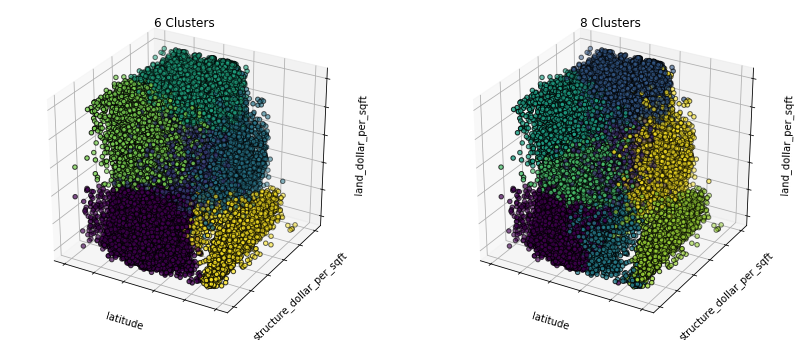

In [30]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='latitude', y_column='structure_dollar_per_sqft', z_column='land_dollar_per_sqft',
                k1=6, k2=8)

As latitude moves east (left on the chart), we can see the land dollar per sqft and structure dollar per sqft increases, indicated by the slope upward as you move back and to the left. (low latitude, high structure dollar per sqft, high land $ per sqft. 

I'm going to go with 8.

In [31]:
def create_k_clusters(train, test, cluster_feature_id, cluster_cols, k):
    kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
    kmeans.fit(train[cluster_cols])
    cluster_feature = 'cluster'+str(cluster_feature_id)+'_id'
    train[cluster_feature] = kmeans.predict(train[cluster_cols])
    test[cluster_feature] = kmeans.predict(test[cluster_cols])
    return train, test, kmeans

In [32]:
train, test, kmeans1 = create_k_clusters(train, test, cluster_feature_id = 1, cluster_cols = cluster1_cols, k=8)

In [33]:
train.rename(index=str, columns={'cluster1_id': 'cluster_loc'}, inplace=True)
test.rename(index=str, columns={'cluster1_id': 'cluster_loc'}, inplace=True)

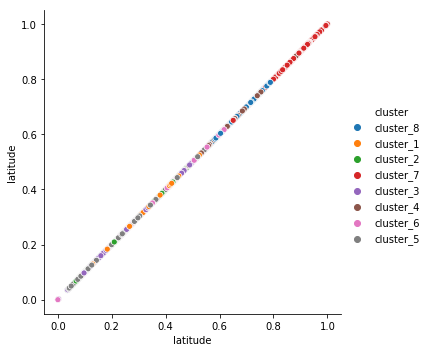

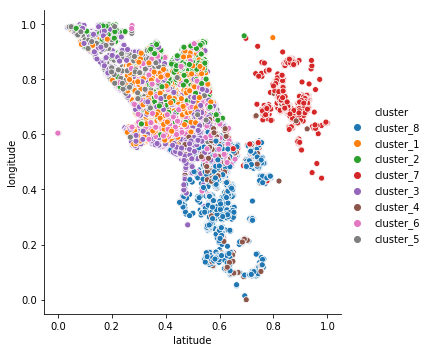

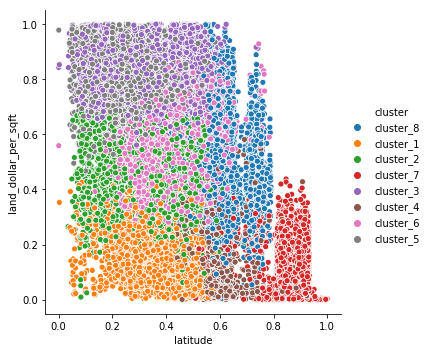

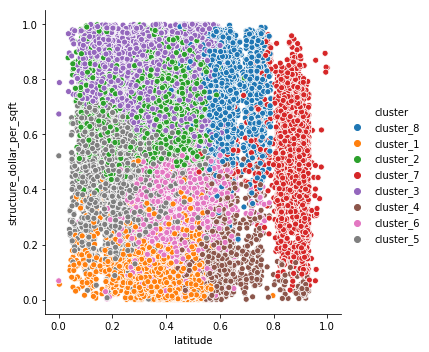

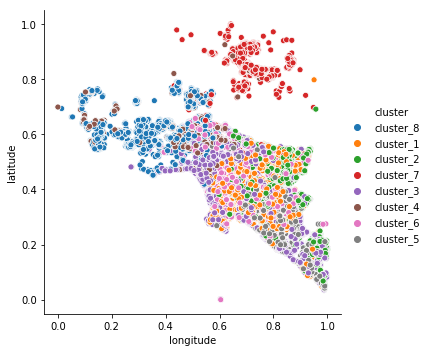

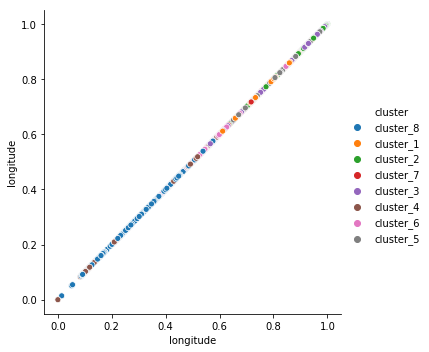

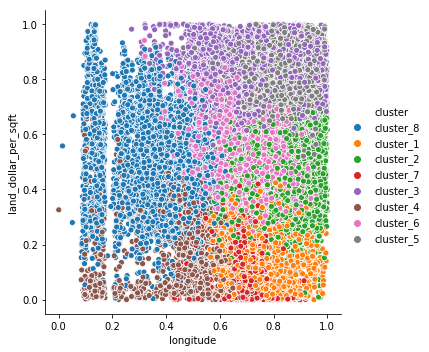

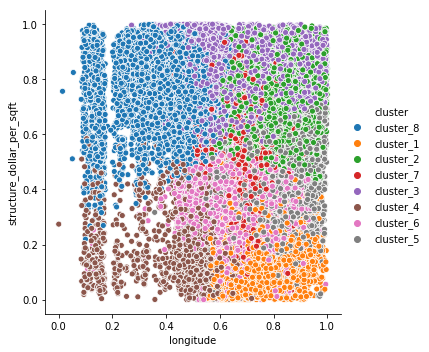

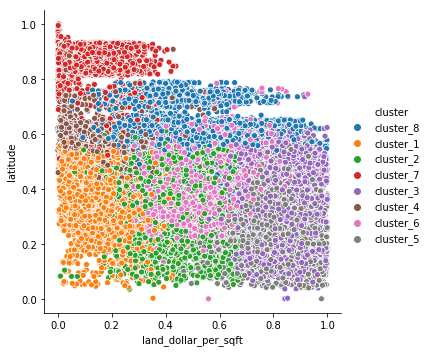

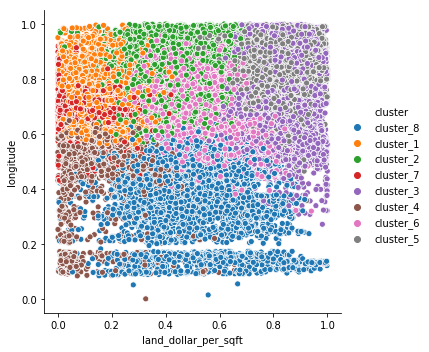

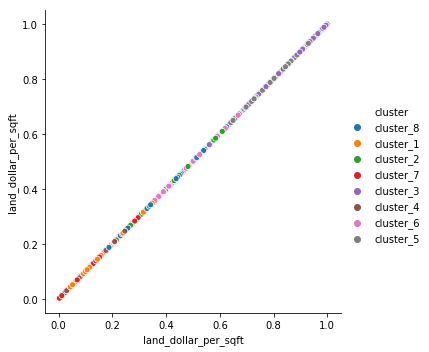

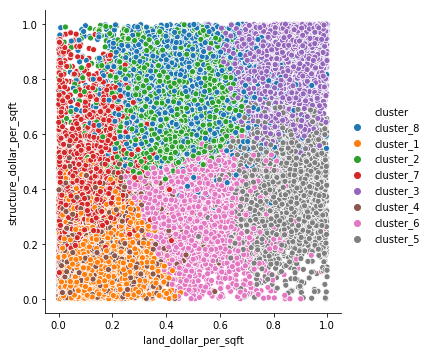

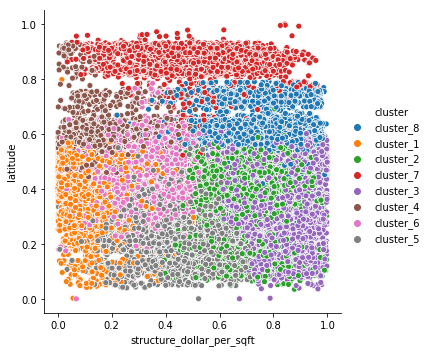

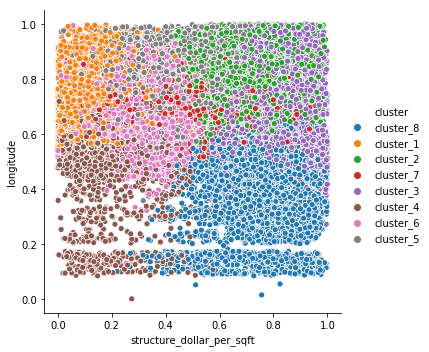

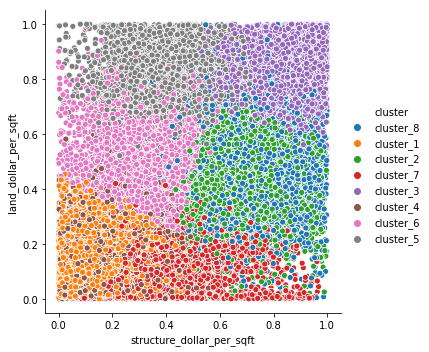

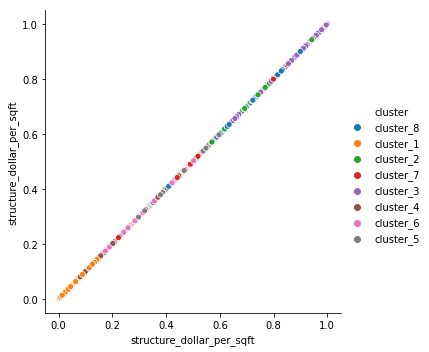

In [34]:
train['cluster'] = kmeans1.labels_
train.cluster = 'cluster_' + (train.cluster + 1).astype('str')
for i in range(0,len(cluster1_cols)):
    for j in range(0, len(cluster1_cols)):
        sns.relplot(data=train, x=cluster1_cols[i], y=cluster1_cols[j], hue='cluster')

In [35]:
train.cluster_loc.value_counts()

2    6018
5    5332
7    5075
0    4956
4    4642
1    4302
6    2576
3    2414
Name: cluster_loc, dtype: int64

In [36]:
test.cluster_loc.value_counts()

2    2490
7    2242
5    2229
0    2163
4    1988
1    1825
6    1156
3    1042
Name: cluster_loc, dtype: int64

##### Clustering 2: size fields and age

In [37]:
cluster2_cols = ['lotsizesquarefeet', 'living_area_sqft', 'bedbath_index','age']

(     k          sse  change_in_sse
 0    1  9831.951381            NaN
 1    2  5597.322476   -4234.628905
 2    3  4411.287398   -1186.035078
 3    4  3466.346800    -944.940598
 4    5  3138.903556    -327.443244
 5    6  2839.585195    -299.318361
 6    7  2546.339094    -293.246101
 7    8  2377.161433    -169.177661
 8    9  2258.199922    -118.961511
 9   10  2129.823418    -128.376504
 10  11  2020.108015    -109.715402
 11  12  1923.519722     -96.588294,
 Text(0.5, 1.0, 'The Elbow Method to find the optimal k'))

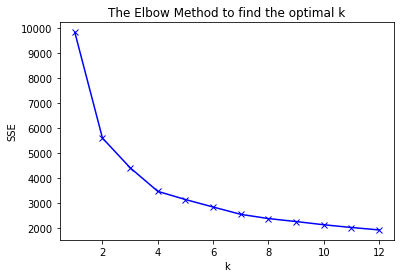

In [38]:
select_k(cluster_df = train[cluster2_cols], ks = range(1,13))

Compare 5 vs. 7 clusters

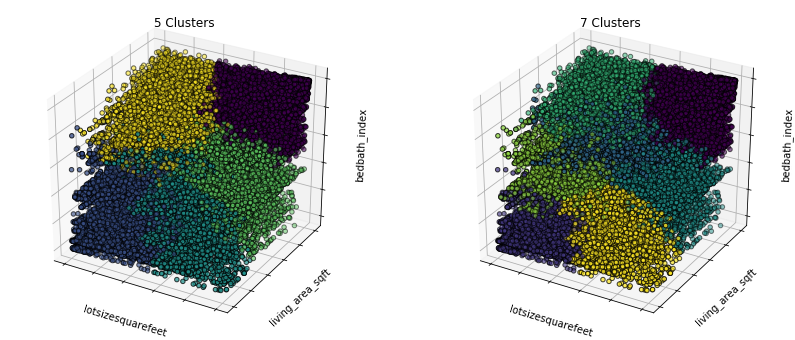

In [39]:
compare_clusters(cluster_df=train[cluster2_cols],
                x_column='lotsizesquarefeet', y_column='living_area_sqft', z_column='bedbath_index',
                k1=5, k2=7)

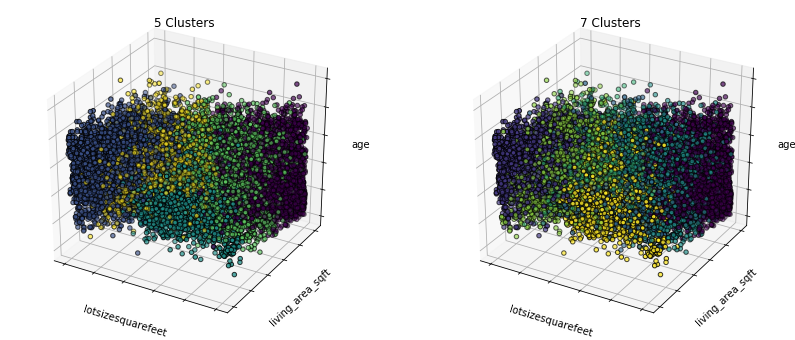

In [40]:
compare_clusters(cluster_df=train[cluster2_cols],
                x_column='lotsizesquarefeet', y_column='living_area_sqft', z_column='age',
                k1=5, k2=7)

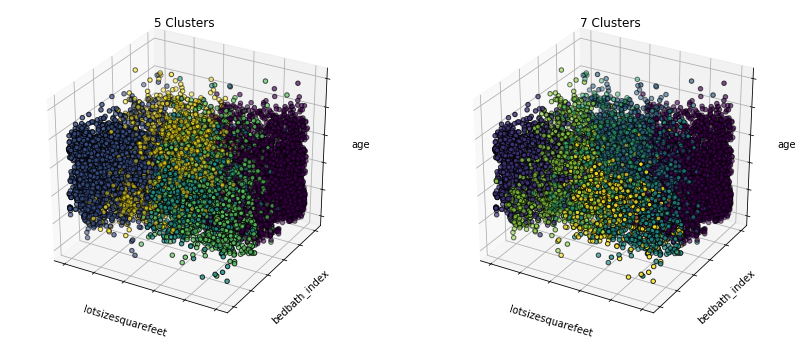

In [41]:
compare_clusters(cluster_df=train[cluster2_cols],
                x_column='lotsizesquarefeet', y_column='bedbath_index', z_column='age',
                k1=5, k2=7)

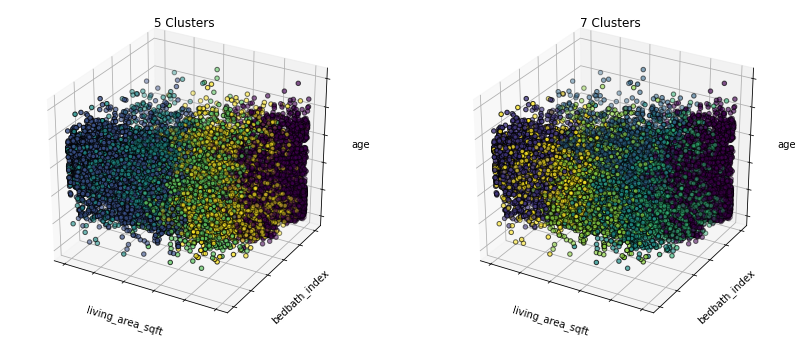

In [42]:
compare_clusters(cluster_df=train[cluster2_cols],
                x_column='living_area_sqft', y_column='bedbath_index', z_column='age',
                k1=5, k2=7)

I'm going to go with 7 clusters.

In [43]:
train, test, kmeans2 = create_k_clusters(train, test, cluster_feature_id = 2, cluster_cols = cluster2_cols, k=7)

In [44]:
train.rename(index=str, columns={'cluster2_id': 'cluster_home'}, inplace=True)
test.rename(index=str, columns={'cluster2_id': 'cluster_home'}, inplace=True)

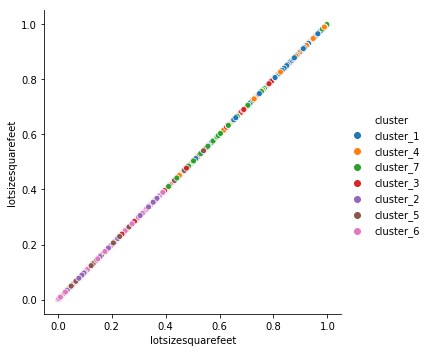

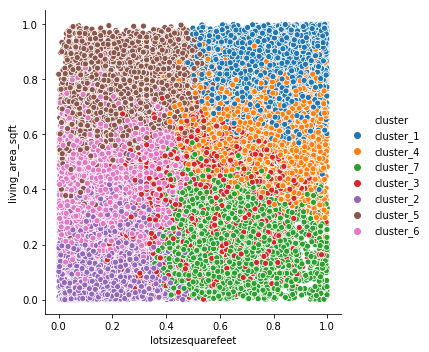

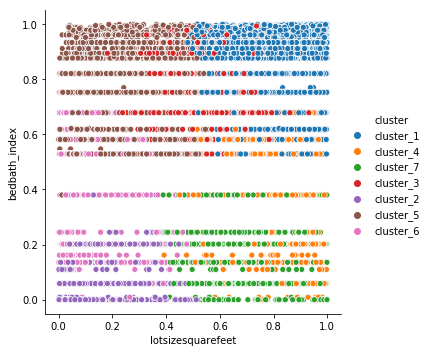

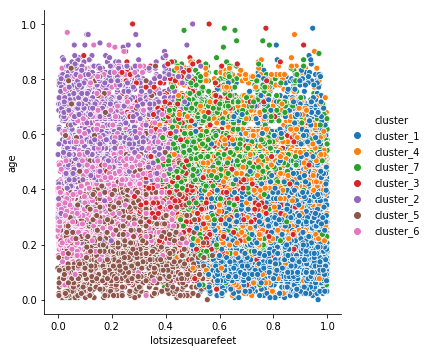

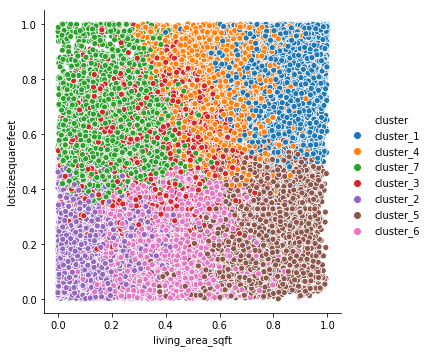

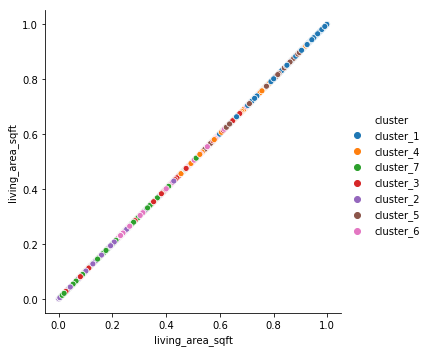

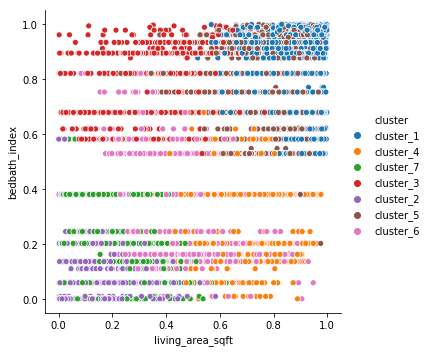

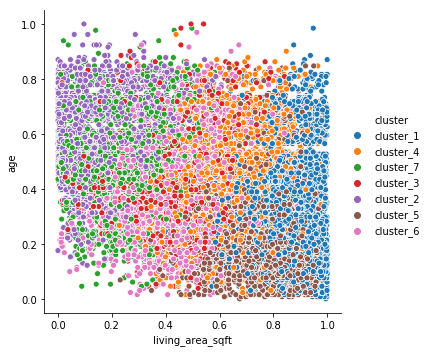

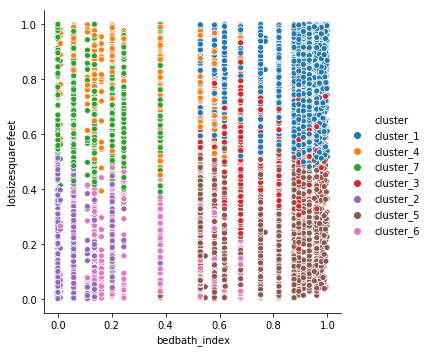

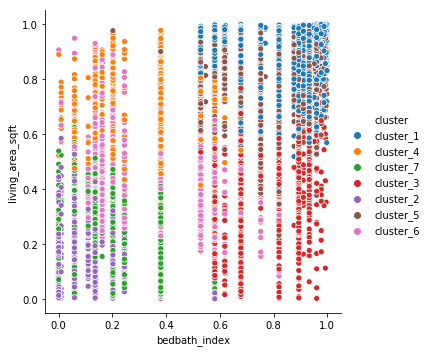

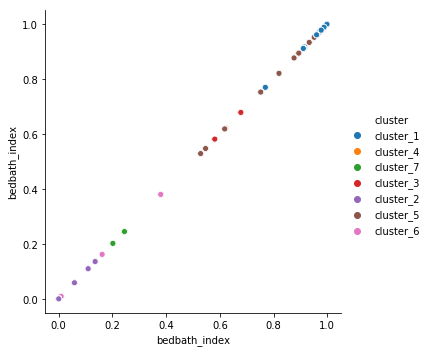

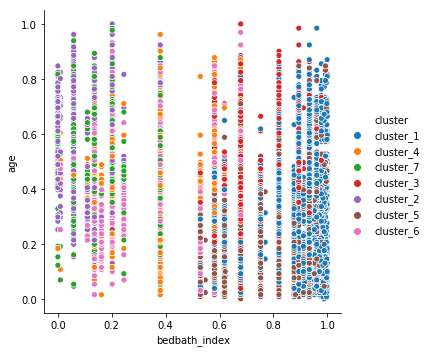

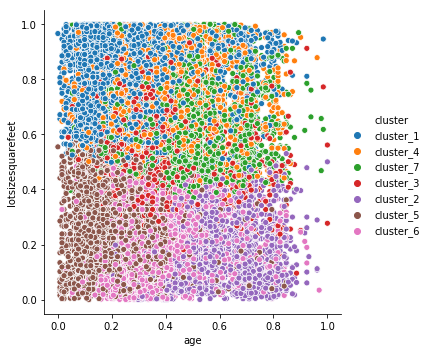

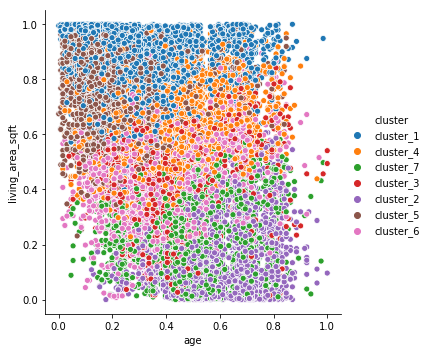

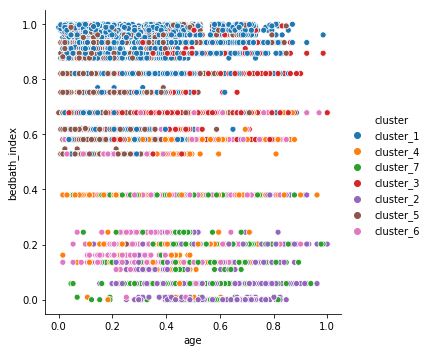

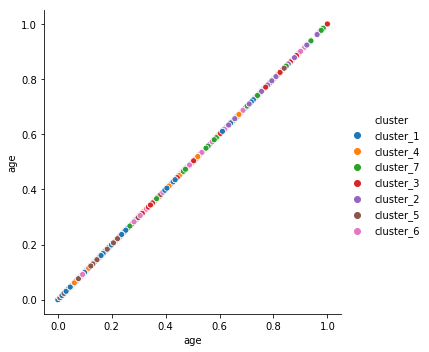

In [45]:
train['cluster'] = kmeans2.labels_
train.cluster = 'cluster_' + (train.cluster + 1).astype('str')

for i in range(0,len(cluster2_cols)):
    for j in range(0, len(cluster2_cols)):
        sns.relplot(data=train, x=cluster2_cols[i], y=cluster2_cols[j], hue='cluster')

### Feature Selection

#### Which variables and clusters give information about logerror?

First, I need to confirm that 'logerror' is normally distributed, to determine if I can run t-tests to test the differences in means across different clusters. 

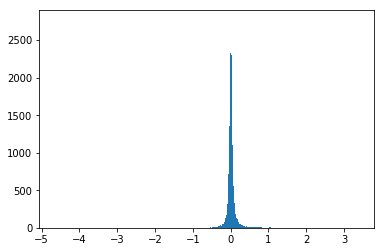

In [46]:
plt.hist(train.logerror, bins=1000)
plt.show()

Looks good!

**Test:** Home driven clusters

First, let's look at the mean log error by cluster id. We will do this for both the train and test as more of a data quality check...to confirm that our cluster id's are showing similar results in both samples. 

In [47]:
train.cluster_home.value_counts()

0    6900
6    5182
5    5119
1    5003
3    4697
4    4546
2    3868
Name: cluster_home, dtype: int64

In [48]:
print(pd.DataFrame(train.groupby(['cluster_home'])['logerror'].mean().reset_index()))
print(pd.DataFrame(test.groupby(['cluster_home'])['logerror'].mean().reset_index()))

   cluster_home  logerror
0             0  0.026697
1             1  0.010745
2             2  0.018982
3             3  0.013154
4             4  0.022594
5             5  0.015432
6             6  0.015425
   cluster_home  logerror
0             0  0.025589
1             1  0.013871
2             2  0.018893
3             3  0.010131
4             4  0.024203
5             5  0.011465
6             6  0.020493


Test the different in the mean logerror for each cluster vs all others. When the p-value is < .05 then we keep the cluster id, else we replace the cluster id with -1. 

In [49]:
import scipy as sp
import numpy as np

less_significant_clusters = []

for i in range(0,max(train.cluster_home)+1):
    stat, pval = sp.stats.ttest_ind(
        train[train.cluster_home == i].logerror.dropna(),
        train[train.cluster_home != i].logerror.dropna())
    if pval > .05:
        less_significant_clusters = less_significant_clusters + [i]

In [50]:
less_significant_clusters

[2, 4, 5, 6]

In [51]:
train.cluster_home = train.cluster_home.replace(less_significant_clusters, -1)
test.cluster_home = test.cluster_home.replace(less_significant_clusters, -1)

In [52]:
test.cluster_home.value_counts()

-1    7801
 0    3114
 3    2125
 1    2095
Name: cluster_home, dtype: int64

In [53]:
train.cluster_home.value_counts()

-1    18715
 0     6900
 1     5003
 3     4697
Name: cluster_home, dtype: int64

**Test:** Location driven clusters

In [54]:
pd.DataFrame(train.groupby(['cluster_loc'])['logerror'].mean().reset_index())

cluster_loc  logerror
0            0  0.026320
1            1  0.018855
2            2  0.011325
3            3  0.017657
4            4  0.019384
5            5  0.022067
6            6  0.014777
7            7  0.013157

In [55]:
less_significant_clusters = []

for i in range(0,max(train.cluster_loc)+1):
    stat, pval = sp.stats.ttest_ind(
        train[train.cluster_loc == i].logerror.dropna(),
        train[train.cluster_loc != i].logerror.dropna())
    if pval > .05:
        less_significant_clusters = less_significant_clusters + [i]

In [56]:
less_significant_clusters

[1, 3, 4, 5, 6]

In [57]:
train.cluster_loc = train.cluster_loc.replace(less_significant_clusters, -1)
test.cluster_loc = test.cluster_loc.replace(less_significant_clusters, -1)

In [58]:
train.cluster_loc.value_counts()

-1    19266
 2     6018
 7     5075
 0     4956
Name: cluster_loc, dtype: int64

**Test:** is_taxdelinquent

In [59]:
pd.DataFrame(train.groupby(['is_taxdelinquent'])['logerror'].mean().reset_index())

is_taxdelinquent  logerror
0               0.0  0.017537
1               1.0  0.028604

In [60]:
stats, pval = sp.stats.ttest_ind(
    train[train.is_taxdelinquent == 0].logerror.dropna(),
    train[train.is_taxdelinquent == 1].logerror.dropna())

if pval > .05:
    train.drop(columns=['is_taxdelinquent'], inplace=True)
    test.drop(columns=['is_taxdelinquent'], inplace=True)

**Data Validation**

In [61]:
print(pval)
# if pval < 0.05 then the column should still exist: 
'is_taxdelinquent' in train.columns

0.02168016063633374


True

**Results:** is_taxdelinquent was correctly left as feature. 

_________________________

**Test:** has_pool

In [62]:
pd.DataFrame(train.groupby(['has_pool'])['logerror'].mean().reset_index())

has_pool  logerror
0       0.0  0.018822
1       1.0  0.014967

In [63]:
stats, pval = sp.stats.ttest_ind(
    train[train.has_pool == 0].logerror.dropna(),
    train[train.has_pool == 1].logerror.dropna())

if pval > .05:
    train.drop(columns=['has_pool'], inplace=True)
    test.drop(columns=['has_pool'], inplace=True)

**Data Validation**

In [64]:
print(pval)
# verify column exists if pval < 0.05, and not if greater
'has_pool' in train.columns

0.08978274948786699


False

**Results:** has_pool was correctly left as feature

____________________________ 

**Test:** has_fireplace

In [65]:
pd.DataFrame(train.groupby(['has_fireplace'])['logerror'].mean().reset_index())

has_fireplace  logerror
0            0.0  0.018137
1            1.0  0.016990

In [66]:
stats, pval = sp.stats.ttest_ind(
    train[train.has_fireplace == 0].logerror.dropna(),
    train[train.has_fireplace == 1].logerror.dropna())

if pval > .05:
    train.drop(columns=['has_fireplace'], inplace=True)
    test.drop(columns=['has_fireplace'], inplace=True)

**Data Validation**

In [67]:
print(pval)
# verify column exists if pval < 0.05, and not if greater
'has_fireplace' in train.columns

0.6715083903831582


False

**Results:** has_fireplace was correctly removed
_______________________

**Test:** has_garage

In [68]:
pd.DataFrame(train.groupby(['has_garage'])['logerror'].mean().reset_index())

has_garage  logerror
0         0.0  0.014790
1         1.0  0.023967

In [69]:
stats, pval = sp.stats.ttest_ind(
    train[train.has_garage == 0].logerror.dropna(),
    train[train.has_garage == 1].logerror.dropna())

if pval > .05:
    train.drop(columns=['has_garage'], inplace=True)
    test.drop(columns=['has_garage'], inplace=True)

**Data Validation**

In [70]:
print(pval)

# verify column exists if pval < 0.05, and not if greater
'has_garage' in train.columns


3.3889972424982125e-06


True

**Results:** has_garage was correctly left as a feature

_______________________

**Clean up remaining features**

In [71]:
train.head()

regionidcity regionidcounty regionidzip  logerror  is_taxdelinquent  \
19165        34278           2061       96351  0.054992               0.0   
18922        46298           3101       96242 -0.014073               0.0   
6982         26964           3101       96150  0.082807               0.0   
66281        16764           1286       97026  0.094705               0.0   
21597         5534           3101       97319  0.315168               1.0   

       has_garage  lotsizesquarefeet  structure_dollar_per_sqft  \
19165         1.0           0.826741                   0.872636   
18922         0.0           0.589256                   0.326713   
6982          0.0           0.692315                   0.784758   
66281         1.0           0.475976                   0.766910   
21597         0.0           0.472016                   0.781111   

       land_dollar_per_sqft  living_area_sqft  tax_rate  bedbath_index  \
19165              0.312171          0.544545  0.746067       0.752252   
18922              0.075951          0.566233  0.299304       0.201702   
6982               0.482390          0.962228  0.518455       0.995996   
66281              0.061244          0.678679  0.782523       0.161662   
21597              0.147561          0.067067  0.086223       0.379880   

       latitude  longitude       age  cluster_loc    cluster  cluster_home  
19165  0.567881   0.287159  0.282443            7  cluster_1             0  
18922  0.341161   0.701653  0.557252            0  cluster_4             3  
6982   0.472848   0.522832  0.580153            7  cluster_1             0  
66281  0.337996   0.891015  0.274809           -1  cluster_4             3  
21597  0.917248   0.682568  0.190840           -1  cluster_7            -1

In [76]:
cols_to_remove = ['tax_rate','regionidcity','regionidzip']
non_cluster_features = ['lotsizesquarefeet', 'structure_dollar_per_sqft', 'land_dollar_per_sqft',
                        'living_area_sqft', 'bedbath_index', 'latitude', 'longitude', 'age']
train_no_clusters = train[non_cluster_features+['regionidcounty','logerror']]
test_no_clusters = test[non_cluster_features+['regionidcounty','logerror']]

In [77]:
cols_to_remove = cols_to_remove + non_cluster_features
cols_to_remove

['tax_rate',
 'regionidcity',
 'regionidzip',
 'lotsizesquarefeet',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'living_area_sqft',
 'bedbath_index',
 'latitude',
 'longitude',
 'age']

In [78]:
train_clusters = train.drop(columns=cols_to_remove+['cluster'])
test_clusters = test.drop(columns=cols_to_remove)

In [79]:
train_no_clusters.head()

lotsizesquarefeet  structure_dollar_per_sqft  land_dollar_per_sqft  \
19165           0.826741                   0.872636              0.312171   
18922           0.589256                   0.326713              0.075951   
6982            0.692315                   0.784758              0.482390   
66281           0.475976                   0.766910              0.061244   
21597           0.472016                   0.781111              0.147561   

       living_area_sqft  bedbath_index  latitude  longitude       age  \
19165          0.544545       0.752252  0.567881   0.287159  0.282443   
18922          0.566233       0.201702  0.341161   0.701653  0.557252   
6982           0.962228       0.995996  0.472848   0.522832  0.580153   
66281          0.678679       0.161662  0.337996   0.891015  0.274809   
21597          0.067067       0.379880  0.917248   0.682568  0.190840   

      regionidcounty  logerror  
19165           2061  0.054992  
18922           3101 -0.014073  
6982            3101  0.082807  
66281           1286  0.094705  
21597           3101  0.315168

In [80]:
train_clusters.head()

regionidcounty  logerror  is_taxdelinquent  has_garage  cluster_loc  \
19165           2061  0.054992               0.0         1.0            7   
18922           3101 -0.014073               0.0         0.0            0   
6982            3101  0.082807               0.0         0.0            7   
66281           1286  0.094705               0.0         1.0           -1   
21597           3101  0.315168               1.0         0.0           -1   

       cluster_home  
19165             0  
18922             3  
6982              0  
66281             3  
21597            -1

### Encode

Which columns are of numeric format but represent classes or categories?
fips
rawcensustractandblock
regionidcity
regionidcounty
regionidzip


In [81]:
def encode(train, test, col_name):
  
    encoded_values = sorted(list(train[col_name].unique()))
    columns = [col_name + '_' + str(val) for val in encoded_values]

    # Integer Encoding
    int_encoder = LabelEncoder()
    train.encoded = int_encoder.fit_transform(train[col_name])
    test.encoded = int_encoder.transform(test[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train.encoded).reshape(len(train.encoded),1)
    test_array = np.array(test.encoded).reshape(len(test.encoded),1)
    
    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=columns, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                               columns=columns, index=test.index)
    test = test.join(test_encoded)

    return train, test, int_encoder, ohe

def one_hot_encode(train, test, col_name):
  
    encoded_values = sorted(list(train[col_name].unique()))
    columns = [col_name + '_' + str(val) for val in encoded_values]

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)
    
    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=columns, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                               columns=columns, index=test.index)
    test = test.join(test_encoded)

    return train, test, ohe

In [82]:
train_clusters, test_clusters, ohe_loc = one_hot_encode(train_clusters, test_clusters, 'cluster_loc')
train_clusters, test_clusters, ohe_home = one_hot_encode(train_clusters, test_clusters, 'cluster_home')

In [83]:
train_clusters.head()

regionidcounty  logerror  is_taxdelinquent  has_garage  cluster_loc  \
19165           2061  0.054992               0.0         1.0            7   
18922           3101 -0.014073               0.0         0.0            0   
6982            3101  0.082807               0.0         0.0            7   
66281           1286  0.094705               0.0         1.0           -1   
21597           3101  0.315168               1.0         0.0           -1   

       cluster_home  cluster_loc_-1  cluster_loc_0  cluster_loc_2  \
19165             0             0.0            0.0            0.0   
18922             3             0.0            1.0            0.0   
6982              0             0.0            0.0            0.0   
66281             3             1.0            0.0            0.0   
21597            -1             1.0            0.0            0.0   

       cluster_loc_7  cluster_home_-1  cluster_home_0  cluster_home_1  \
19165            1.0              0.0             1.0             0.0   
18922            0.0              0.0             0.0             0.0   
6982             1.0              0.0             1.0             0.0   
66281            0.0              0.0             0.0             0.0   
21597            0.0              1.0             0.0             0.0   

       cluster_home_3  
19165             0.0  
18922             1.0  
6982              0.0  
66281             1.0  
21597             0.0

Build 3 models, 1 for each county
Try with clusters and then try with original features

In [84]:
train_clusters.regionidcounty.value_counts()

3101    22834
1286     9485
2061     2996
Name: regionidcounty, dtype: int64

Separate the clusters dataframes by county

In [85]:
train_3101_c = train_clusters[train_clusters.regionidcounty=='3101']
test_3101_c = test_clusters[test_clusters.regionidcounty=='3101']

train_1286_c = train_clusters[train_clusters.regionidcounty=='1286']
test_1286_c = test_clusters[test_clusters.regionidcounty=='1286']

train_2061_c = train_clusters[train_clusters.regionidcounty=='2061']
test_2061_c = test_clusters[test_clusters.regionidcounty=='2061']

Separate the non-clusters dataframes by county

In [86]:
train_3101_nc = train_no_clusters[train_no_clusters.regionidcounty=='3101']
test_3101_nc = test_no_clusters[test_no_clusters.regionidcounty=='3101']

train_1286_nc = train_no_clusters[train_no_clusters.regionidcounty=='1286']
test_1286_nc = test_no_clusters[test_no_clusters.regionidcounty=='1286']

train_2061_nc = train_no_clusters[train_no_clusters.regionidcounty=='2061']
test_2061_nc = test_no_clusters[test_no_clusters.regionidcounty=='2061']

Now that we have encoded and split by county, we can remove some other columns to have our final X with features.
We only need a y_train and y_test for each county, not separated by the features, obviously. 

X dataframes for the cluster features:

In [87]:
cols_to_drop = ['cluster_loc', 'cluster_home', 'cluster_loc_-1', 'cluster_home_-1', 'logerror', 'regionidcounty']

X_train_3101_c = train_3101_c.drop(columns=cols_to_drop)
X_test_3101_c = test_3101_c.drop(columns=cols_to_drop)

X_train_1286_c = train_1286_c.drop(columns=cols_to_drop)
X_test_1286_c = test_1286_c.drop(columns=cols_to_drop)

X_train_2061_c = train_2061_c.drop(columns=cols_to_drop)
X_test_2061_c = test_2061_c.drop(columns=cols_to_drop)

X dataframes for the non-cluster features

In [88]:
cols_to_drop = ['logerror', 'regionidcounty']

X_train_3101_nc = train_3101_nc.drop(columns=cols_to_drop)
X_test_3101_nc = test_3101_nc.drop(columns=cols_to_drop)

X_train_1286_nc = train_1286_nc.drop(columns=cols_to_drop)
X_test_1286_nc = test_1286_nc.drop(columns=cols_to_drop)

X_train_2061_nc = train_2061_nc.drop(columns=cols_to_drop)
X_test_2061_nc = test_2061_nc.drop(columns=cols_to_drop)

y dataframes

In [89]:
y_train_3101 = train_3101_c[['logerror']]
y_test_3101 = test_3101_c[['logerror']]

y_train_1286 = train_1286_c[['logerror']]
y_test_1286 = test_1286_c[['logerror']]

y_train_2061 = train_2061_c[['logerror']]
y_test_2061 = test_2061_c[['logerror']]

## Model

In [90]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.tree import DecisionTreeRegressor

### county: 3101

#### Baseline

In [91]:
se = y_train_3101.logerror * y_train_3101.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.014235182076368291

#### Clustering Features

##### Linear Support Vector Regressor from sklearn.svm

In [92]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = regr.predict(X_train_3101_c)
print(mean_squared_error(y_train_3101, y_pred_3101)**1/2)

0.0141388595901456


##### Support Gradient Descent Regressor from sklearn.linear_model

In [93]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = sgd.predict(X_train_3101_c)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.014138891385517008

##### Lasso with Cross Validation from sklearn.linear_model

In [94]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = lasso.predict(X_train_3101_c)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.014139640198215307

##### Decision Tree Regressor from sklearn.tree

In [95]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = dt.predict(X_train_3101_c)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.014073249134612041

#### non-clustering features

##### Linear Support Vector Regressor from sklearn.svm

In [96]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = regr.predict(X_train_3101_nc)
print(mean_squared_error(y_train_3101, y_pred_3101)**1/2)

0.014067948026803678


##### Support Gradient Descent Regressor from sklearn.linear_model

In [97]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = sgd.predict(X_train_3101_nc)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.01407143090395119

##### Lasso with Cross Validation from sklearn.linear_model

In [98]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = lasso.predict(X_train_3101_nc)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.014069047283143435

##### Decision Tree Regressor from sklearn.tree

In [99]:
dt = DecisionTreeRegressor(max_depth=10, random_state=123)
dt.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = dt.predict(X_train_3101_nc)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.012288335440825391

WOW?!?!

### county: 1286

#### Baseline

In [100]:
se = y_train_1286.logerror * y_train_1286.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.020229398397867752

#### Clustering Features

##### Linear Support Vector Regressor from sklearn.svm

In [101]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_1286_c, y_train_1286)
y_pred_1286 = regr.predict(X_train_1286_c)
print(mean_squared_error(y_train_1286, y_pred_1286)**1/2)

0.019838280584398238


##### Support Gradient Descent Regressor from sklearn.linear_model

In [102]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_1286_c, y_train_1286)
y_pred_1286 = sgd.predict(X_train_1286_c)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.019838297810517488

##### Lasso with Cross Validation from sklearn.linear_model

In [103]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_1286_c, y_train_1286)
y_pred_1286 = lasso.predict(X_train_1286_c)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.019850840180237694

##### Decision Tree Regressor from sklearn.tree

In [104]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_1286_c, y_train_1286)
y_pred_1286 = dt.predict(X_train_1286_c)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.01972552630013377

#### non-clustering features

##### Linear Support Vector Regressor from sklearn.svm

In [105]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_1286_nc, y_train_1286)
y_pred_1286 = regr.predict(X_train_1286_nc)
print(mean_squared_error(y_train_1286, y_pred_1286)**1/2)

0.019802786770940738


##### Support Gradient Descent Regressor from sklearn.linear_model

In [106]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_1286_nc, y_train_1286)
y_pred_3101 = sgd.predict(X_train_1286_nc)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.019802786770940738

##### Lasso with Cross Validation from sklearn.linear_model

In [107]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_1286_nc, y_train_1286)
y_pred_1286 = lasso.predict(X_train_1286_nc)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.019819173216702107

##### Decision Tree Regressor from sklearn.tree

In [108]:
dt = DecisionTreeRegressor(max_depth=10, random_state=123)
dt.fit(X_train_1286_nc, y_train_1286)
y_pred_1286 = dt.predict(X_train_1286_nc)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.01421778300080756

WOW again!?!

### county: 2061

#### Baseline

In [109]:
se = y_train_2061.logerror * y_train_2061.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.013489873773480028

#### Clustering Features

##### Linear Support Vector Regressor from sklearn.svm

In [110]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_2061_c, y_train_2061)
y_pred_2061 = regr.predict(X_train_2061_c)
print(mean_squared_error(y_train_2061, y_pred_2061)**1/2)

0.013292181433479745


##### Support Gradient Descent Regressor from sklearn.linear_model

In [111]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_2061_c, y_train_2061)
y_pred_2061 = sgd.predict(X_train_2061_c)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.013292341769156377

##### Lasso with Cross Validation from sklearn.linear_model

In [112]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_2061_c, y_train_2061)
y_pred_2061 = lasso.predict(X_train_2061_c)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.0133764459430497

##### Decision Tree Regressor from sklearn.tree

In [113]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_2061_c, y_train_2061)
y_pred_2061 = dt.predict(X_train_2061_c)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.01307324925551126

#### non-clustering features

##### Linear Support Vector Regressor from sklearn.svm

In [114]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_2061_nc, y_train_2061)
y_pred_2061 = regr.predict(X_train_2061_nc)
print(mean_squared_error(y_train_2061, y_pred_2061)**1/2)

0.013372754344849679


##### Support Gradient Descent Regressor from sklearn.linear_model

In [115]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_2061_nc, y_train_2061)
y_pred_2061 = sgd.predict(X_train_2061_nc)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.013372862011285238

##### Lasso with Cross Validation from sklearn.linear_model

In [116]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_2061_nc, y_train_2061)
y_pred_2061 = lasso.predict(X_train_2061_nc)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.013386721984390976

##### Decision Tree Regressor from sklearn.tree

In [117]:
dt = DecisionTreeRegressor(max_depth=5, random_state=123)
dt.fit(X_train_2061_nc, y_train_2061)
y_pred_2061 = dt.predict(X_train_2061_nc)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.011146664700412421

In [118]:
y_pred_2061 = dt.predict(X_test_2061_nc)
mean_squared_error(y_test_2061, y_pred_2061)**1/2

0.010496344800006935

In [119]:
y_pred_2061 = regr.predict(X_test_2061_nc)
print(mean_squared_error(y_test_2061, y_pred_2061)**1/2)

0.009295619753592705


In [120]:
10**train.logerror.describe()

count            inf
mean        1.042259
std         1.502287
min         0.000022
25%         0.944738
50%         1.015709
75%         1.096963
max      2480.527609
Name: logerror, dtype: float64